# M77 Coursework: 3D "Pac-Man"
The following coursework is designed to test multiple components of the module sylabus; including 3D geometry, object detection, feature extraction and image manipulation.

Your task is to complete the below skeleton code to play a Pac-Man-esque game in 3D. You are allowed to utilise method discussed in the course, including feature extractors and deep learning approaches.

The aim of the coursework is to step through a 3D pointcloud of the old PhD lab at Swansea University. Several large spheres have been placed within the space, it is your job to move through the pointcloud in an automated fashion, detecting the location of the sphere and moving to the predicted 3D location. If you land close enough to a sphere it will be captured and removed from the pointcloud. 

You will need to decide what kinds of feature you want to use, extract these features and train a classifier to detect the spheres within an image. You can then use the functionality provided in the PacMan_functionality.py module to obtain the XYZ coordinates of the pixel you predict to be a sphere.


## Imports
Hre we will do our usual imports. I would recommend numpy, scipy, skimage, matplotlib and sklearn. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_functionality module as well.

In [1]:
!pip install -U scikit-learn ensemble

In [2]:
!pip install scipy

In [3]:
!pip install torch

In [1]:
# Required imports
import PacMan_functionality as PacMan
import open3d

# For ndarray handling:
import numpy as np

# For Operating System tools and file finding:
import os
import glob

import matplotlib.pyplot as plt
import cv2

#Use for classification
# from sklearn.ensemble import RandomForestClassifier
# from scipy import sklearn

import sklearn
import skimage
#For the confusion Matrix
from sklearn import metrics
# sklearn.ensemble.RandomForestClassifier class

import tensorflow as tf

#Times how long the model takes to Collect all the spheres
import time

#Using RCNN
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from rs_cnn import RS_CNN  # import the RS-CNN model
# from dataset import PointCloudDataset  # import your custom dataset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sklearn.ensemble

In [3]:
import scipy; print(scipy.__version__)

1.10.1


## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [4]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [5]:
# View our pointcloud if we want
pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(global_cloud['Positions']))
pcd.colors = open3d.utility.Vector3dVector(global_cloud['Colors']/255)

open3d.visualization.draw_geometries([pcd])

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towars them.

In [6]:
# Get the training samples for both positive and negative patches
# Get list of filenames for photos with checkerboard pattern
# path_to_data = os.path.join'./TrainingImages' # Edit this if data is another directory
# positive_filenames = glob.glob(path_to_data + '/negatives/*')
# negative_filenames = glob.glob(path_to_data + '/positives/*')

# pos_files = os.listdir(positive_filenames)

positive_filenames = os.path.join('.','TrainingImages','positives')
negative_filenames = os.path.join('.','TrainingImages','negatives')

pos_files = os.listdir(positive_filenames)
neg_files = os.listdir(negative_filenames)

# plt.imread(os.path.join(positive_filenames, pos_files[0]))

# plt.imshow(plt.imread(os.path.join(positive_filenames, pos_files[0])))

pos_images = []
neg_images = []
for i_files in pos_files:
    pos_images.append(plt.imread(os.path.join(positive_filenames, i_files)))
for i_files in neg_files:
    neg_images.append(plt.imread(os.path.join(negative_filenames, i_files)))

# n_pos_files = len(positive_filenames)
# n_neg_files = len(negative_filenames)
# for i_file in range(n_pos_files):
#     pos_images.append(cv2.imread(positive_filenames[i_file]))
# for i_file in range(n_neg_files):
#     neg_images.append(cv2.imread(negative_filenames[i_file]))
# # Concatenate the patches into a 4D numpy array (S*H*W*C), and create a label vector (S)
training_data = np.concatenate([neg_images,pos_images])
training_labels = np.concatenate([np.zeros(len(neg_images)), np.ones(len(pos_images))])
# print(con.shape)

In [7]:
print(training_data.shape)
print(training_labels.shape)

(2036, 51, 51, 3)
(2036,)


In [8]:
print(spheres_collected)

[False, False, False, False, False, False, False, False, False, False, False]


In [29]:
# n_pos_files = len(positive_filenames)
# n_neg_files = len(negative_filenames)
# pos_images = []
# neg_images = []
# for i_file in range(n_pos_files):
#     pos_images.append(np.load(positive_filenames[i_file],allow_pickle=True))
# for i_file in range(n_neg_files):
#     neg_images.append(np.load(negative_filenames[i_file],allow_pickle=True))
# print(n_pos_files)
# print(n_neg_files)
# print(f'Left image shapes are: {left_images[0].shape}')
# print(f'Right image shapes are: {right_images[0].shape}')

## Train a classifier on the samples, this may require feature extraction on the patches
Depending on your desired apporach you may want to extract features on the training patches you have been given. These can then be used to train our desired classifier to detect the patches based not on the raw data, but on a representative feature descriptor. Several are talked about both in the lectures and labs. 

In [30]:
# Extract the features - maybe, might not be needed with representation learning approaches
extracted_features = []
for i in training_data:
    extracted_features.append(skimage.feature.hog(i, channel_axis=-1))
extracted_features = np.asarray(extracted_features)

print(extracted_features.shape)

(2036, 1296)


In [31]:
# Creating Models: Random Forest Classificiation

In [32]:
# Train a classification model to perform binary classification of the patch into whether it contains a sphere or not.
model = sklearn.ensemble.RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=15)
#Flatterning data and add labels so model associates data with labels
# model.fit(np.reshape(training_data, (training_data.shape[0],-1)), training_labels)
model.fit(extracted_features, training_labels)

# model.predict(np.reshape(training_data, (training_data.shape[0],-1))[0:1])

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    3.9s finished


RandomForestClassifier(n_estimators=500, n_jobs=10, verbose=1)

In [33]:
# #My version using RCNN

# # define hyperparameters
# batch_size = 32
# learning_rate = 0.001
# num_epochs = 10

# # define the transforms to apply to each point cloud
# data_transforms = transforms.Compose([
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # create the dataloader
# dataloader = DataLoader(global_cloud, batch_size=batch_size, shuffle=True)

# # create the RS-CNN model
# model = RS_CNN(num_classes=1)

# # define the loss function and optimizer
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # train the model
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(dataloader, 0):
#         # get the inputs and labels
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0
            
# print('Finished training')

# # save the trained model
# torch.save(model.state_dict(), 'sphere_detection_model.pth')

In [34]:
# Version of CNN
# model = tf.keras.Sequential(layers=[
#     tf.keras.layers.Dense(4, activation=tf.nn.relu),
#     tf.keras.layers.Dense(10, activation=tf.nn.relu),
#     tf.keras.layers.Dense(len(np.unique(y_trn)), activation=tf.nn.softmax)])
# # model = sklearn.ensemble.RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=10)

# model.fit(extracted_features, training_labels)

## Initialise our starting point in the game and get our first view into the scene
We should start the game at a position of XYZ = [0, 0, 0] and a camera angle of [0, 0, 0]. These variables can be updated once we find a sphere, or rotated when we don't find a sphere. We can then get our first image projected to the camera plane to start our game. 

In [35]:
# Initialise position and angle variable 
position = np.zeros([3])
angle = np.zeros([3])

In [36]:
# Get the image, XYZ maps and depth map of the current viewpoint into the scene
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

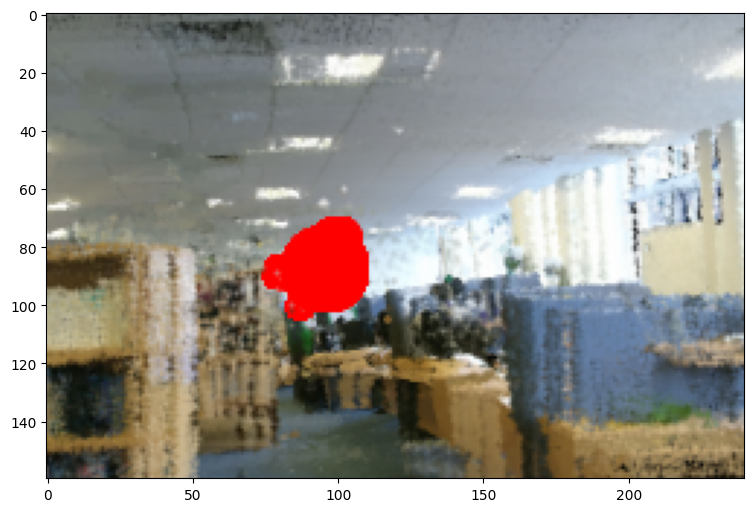

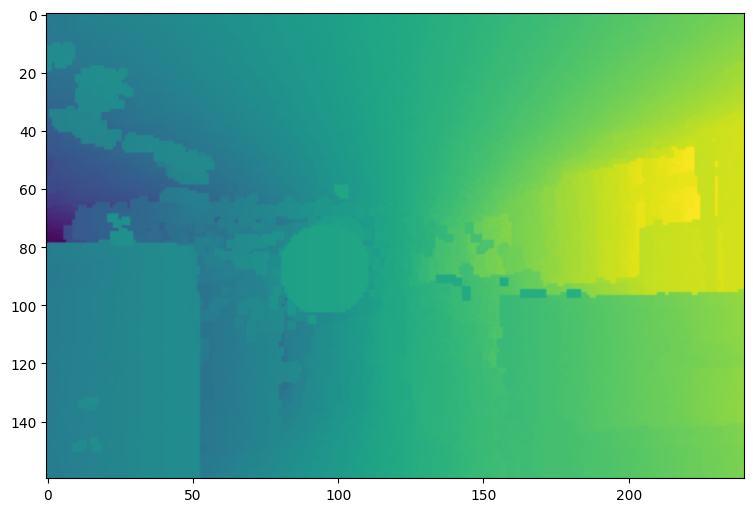

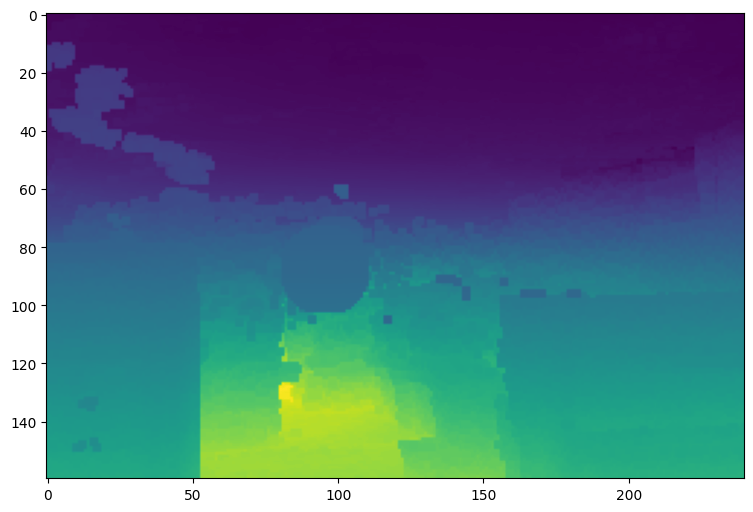

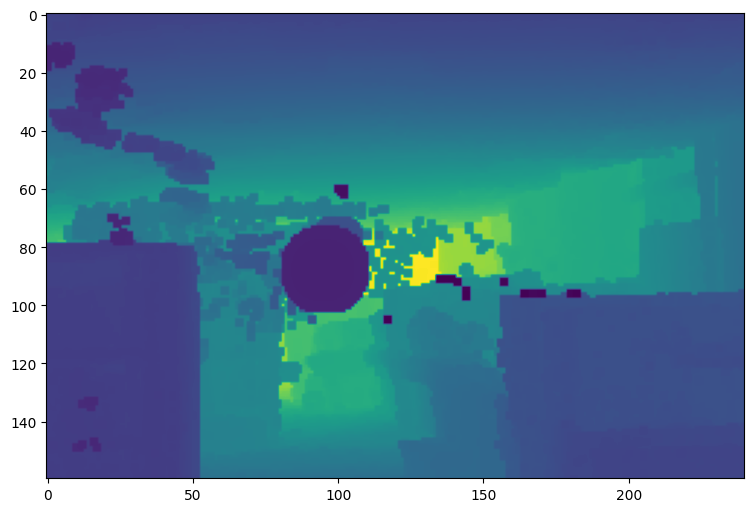

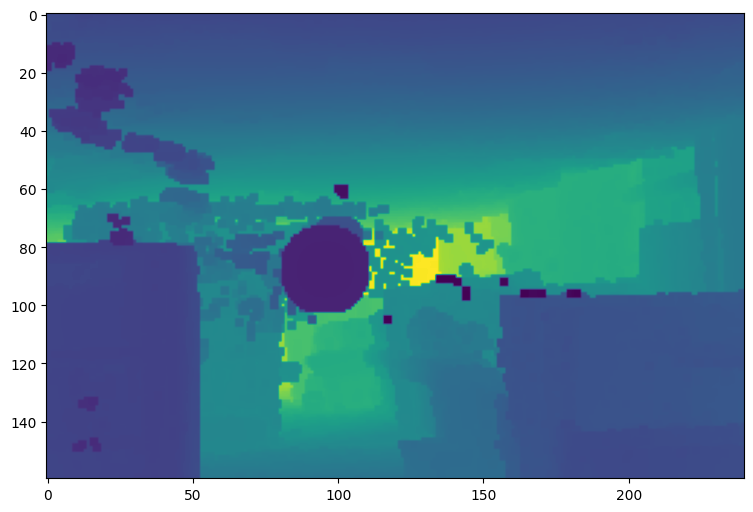

In [37]:
plt.figure()
plt.imshow(image)

plt.figure()
plt.imshow(mapx)

plt.figure()
plt.imshow(mapy)

plt.figure()
plt.imshow(mapz)

plt.figure()
plt.imshow(depth)

## Perform our loop, in which we will perform pixel-wise prediction on binary class label and then perform the correct action based on detection of spheres.
This will be the main bulk of your implementation, utilising the feature descriptors and trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene
-  Extract patches from the scene
-  Extract features on the patches
-  Use the pretrained model to obtain class prediction probabilities
-  Identify if a sphere has been found in the scene
  -  If so, find the mapped XYZ location, move there and update the scene
  -  If not, rotate the camera in a bid to find the sphere


In [38]:
print(spheres_collected)
sphere_counter = sum(spheres_collected)
print(sphere_counter)

[False, False, False, False, False, False, False, False, False, False, False]
0


Capturing Image


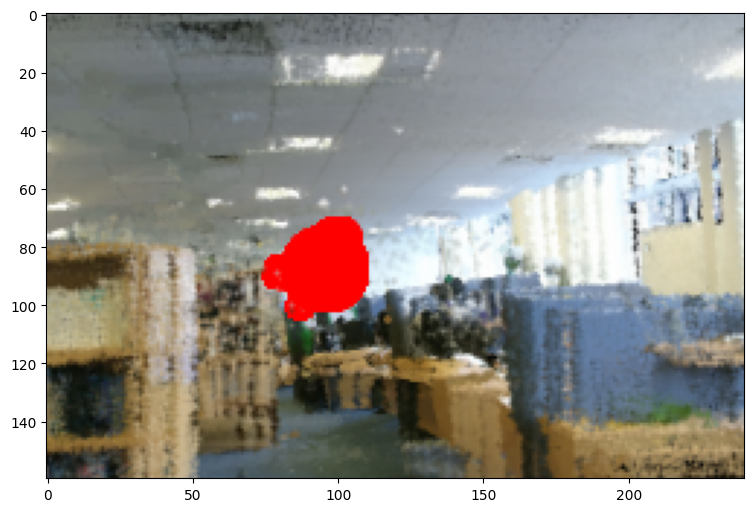

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.6s finished


Prediction Probability:  [[0.976 0.024]
 [0.976 0.024]
 [0.962 0.038]
 ...
 [0.994 0.006]
 [0.99  0.01 ]
 [0.996 0.004]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


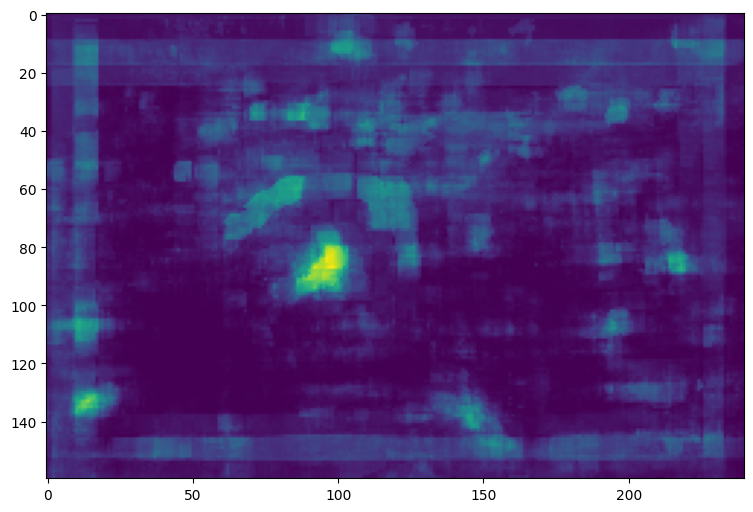

Updating Camera Position
New position: [-0.18056911  0.05662879  2.31025685]
Updating scene and list of collected spheres.
I have found 1 out of 11 spheres!
Position: [-0.18056911  0.05662879  2.31025685]
Previous Position: [-0.18056911  0.05662879  2.31025685]
Capturing Image


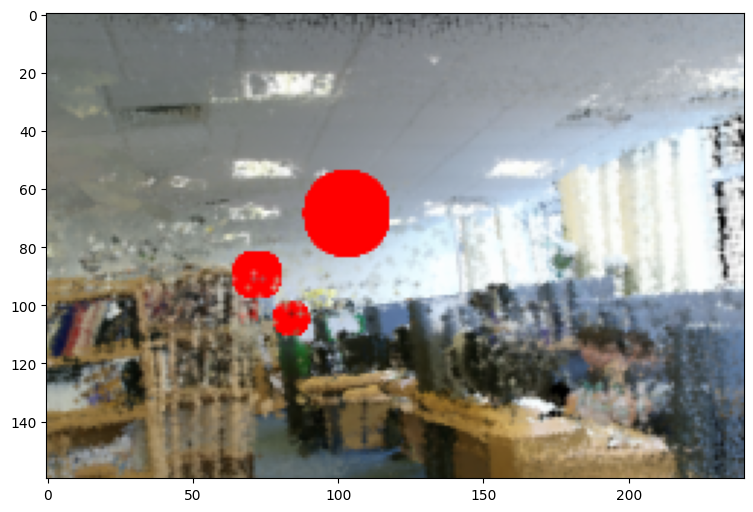

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.6s finished


Prediction Probability:  [[0.976 0.024]
 [0.974 0.026]
 [0.952 0.048]
 ...
 [0.98  0.02 ]
 [0.998 0.002]
 [0.998 0.002]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


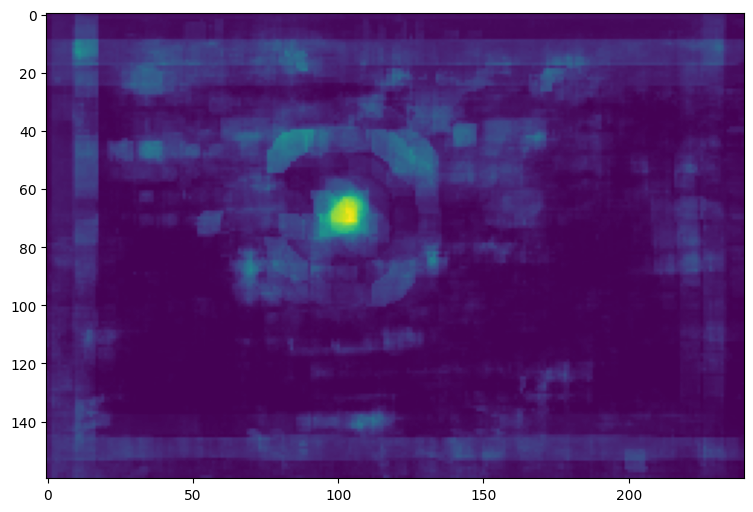

Updating Camera Position
New position: [-0.31447777 -0.02599192  4.67416503]
Updating scene and list of collected spheres.
I have found 2 out of 11 spheres!
Position: [-0.31447777 -0.02599192  4.67416503]
Previous Position: [-0.31447777 -0.02599192  4.67416503]
Capturing Image


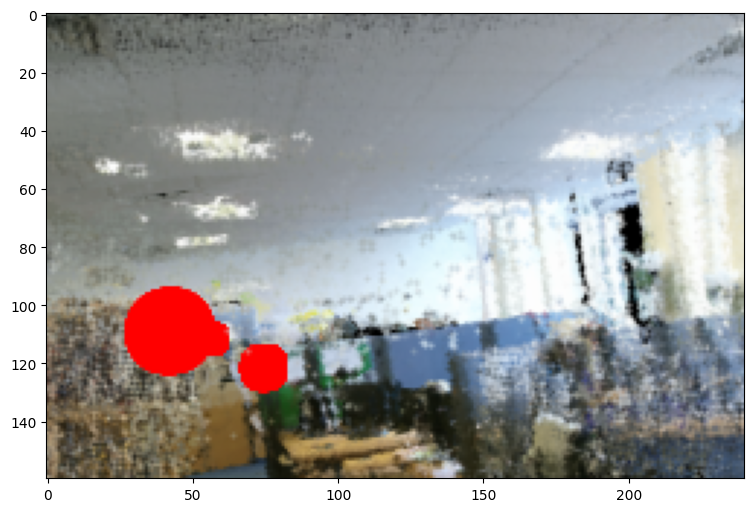

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.97  0.03 ]
 [0.97  0.03 ]
 [0.958 0.042]
 ...
 [0.938 0.062]
 [0.938 0.062]
 [0.95  0.05 ]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


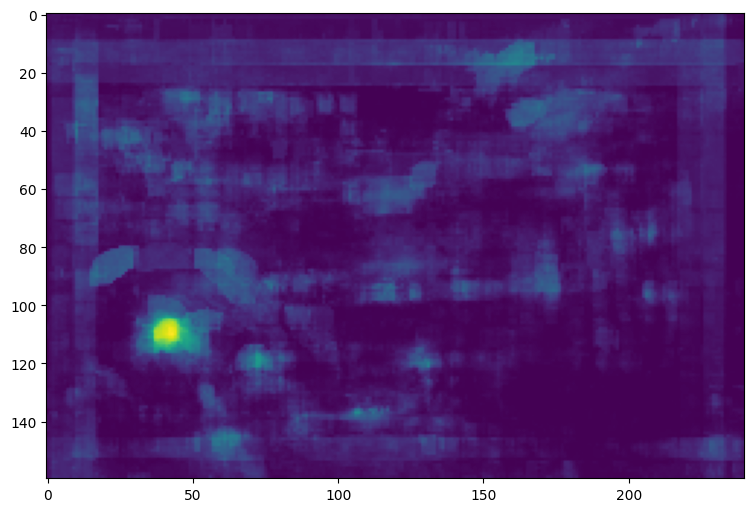

Updating Camera Position
New position: [-0.9208141   0.19936847  7.01182695]
Updating scene and list of collected spheres.
I have found 3 out of 11 spheres!
Position: [-0.9208141   0.19936847  7.01182695]
Previous Position: [-0.9208141   0.19936847  7.01182695]
Capturing Image


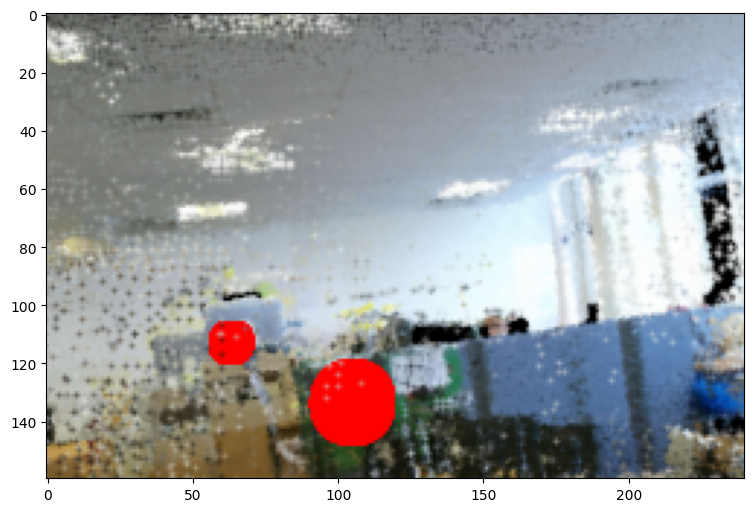

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.97  0.03 ]
 [0.97  0.03 ]
 [0.964 0.036]
 ...
 [0.958 0.042]
 [0.968 0.032]
 [0.98  0.02 ]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


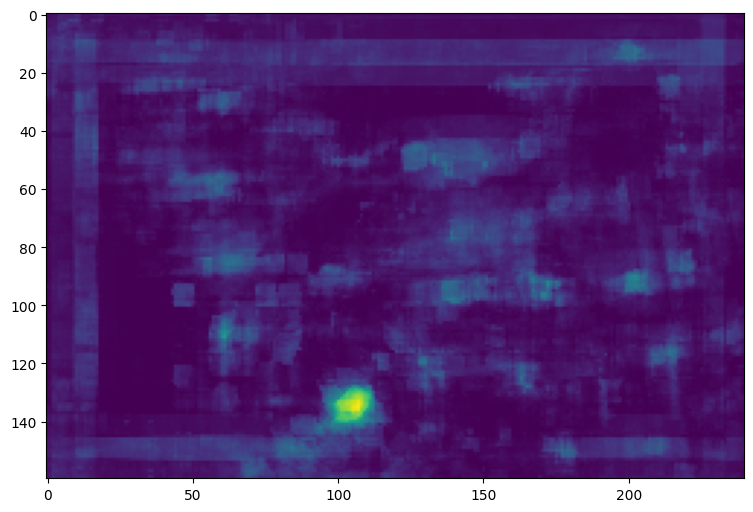

Updating Camera Position
New position: [-1.03476982  0.62195517  9.37855697]
Updating scene and list of collected spheres.
I have found 4 out of 11 spheres!
Position: [-1.03476982  0.62195517  9.37855697]
Previous Position: [-1.03476982  0.62195517  9.37855697]
Capturing Image


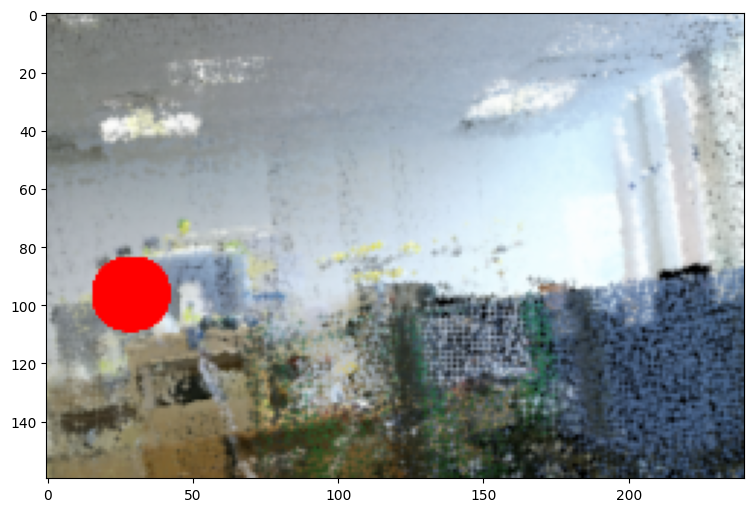

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.964 0.036]
 [0.96  0.04 ]
 [0.948 0.052]
 ...
 [0.996 0.004]
 [0.996 0.004]
 [0.998 0.002]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


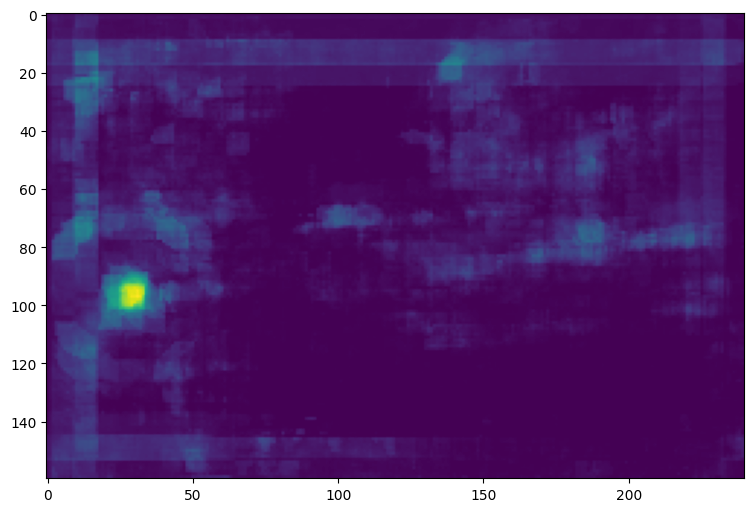

Updating Camera Position
New position: [-1.87995924  0.77358276 12.18065769]
Updating scene and list of collected spheres.
I have found 5 out of 11 spheres!
Position: [-1.87995924  0.77358276 12.18065769]
Previous Position: [-1.87995924  0.77358276 12.18065769]
Capturing Image


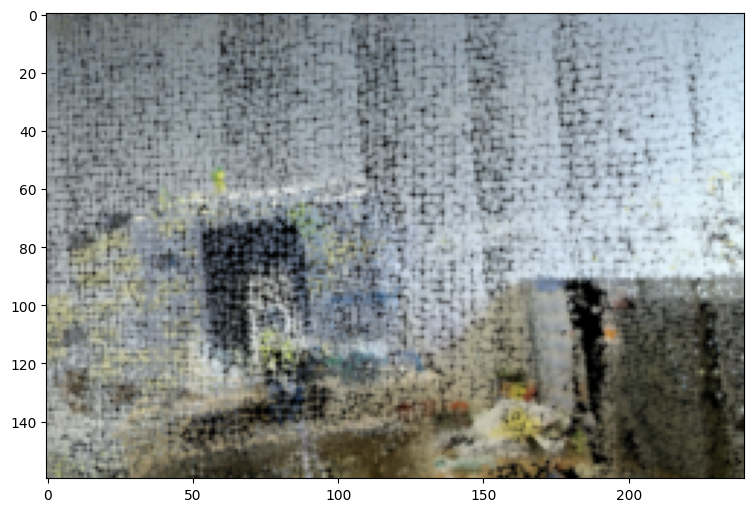

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.976 0.024]
 [0.97  0.03 ]
 [0.952 0.048]
 ...
 [0.984 0.016]
 [0.984 0.016]
 [0.99  0.01 ]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
No sphere found. Roating camera
Capturing Image


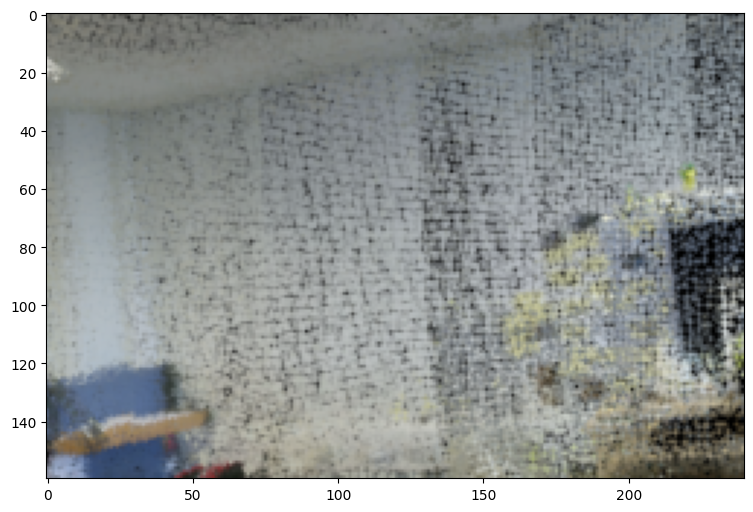

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.6s finished


Prediction Probability:  [[0.978 0.022]
 [0.972 0.028]
 [0.962 0.038]
 ...
 [0.968 0.032]
 [0.986 0.014]
 [0.988 0.012]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
No sphere found. Roating camera
Capturing Image


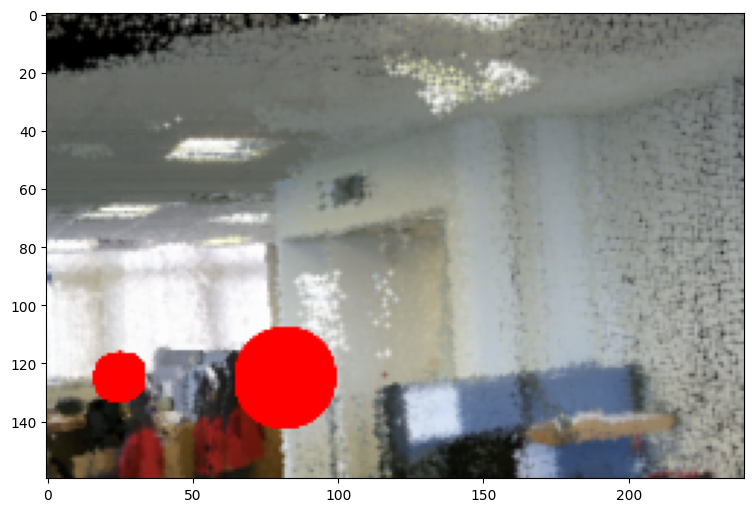

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.912 0.088]
 [0.92  0.08 ]
 [0.864 0.136]
 ...
 [0.978 0.022]
 [0.994 0.006]
 [0.986 0.014]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


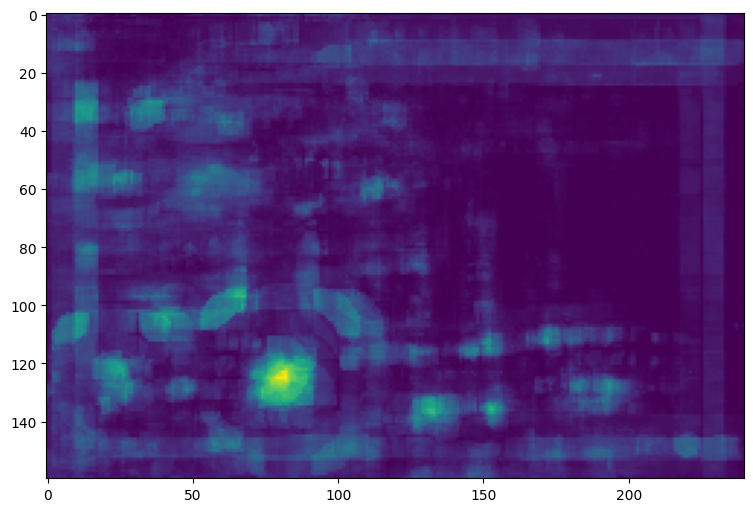

Updating Camera Position
New position: [-3.73031055  1.07164149 12.95637962]
Updating scene and list of collected spheres.
I have found 6 out of 11 spheres!
Position: [-3.73031055  1.07164149 12.95637962]
Previous Position: [-3.73031055  1.07164149 12.95637962]
Capturing Image


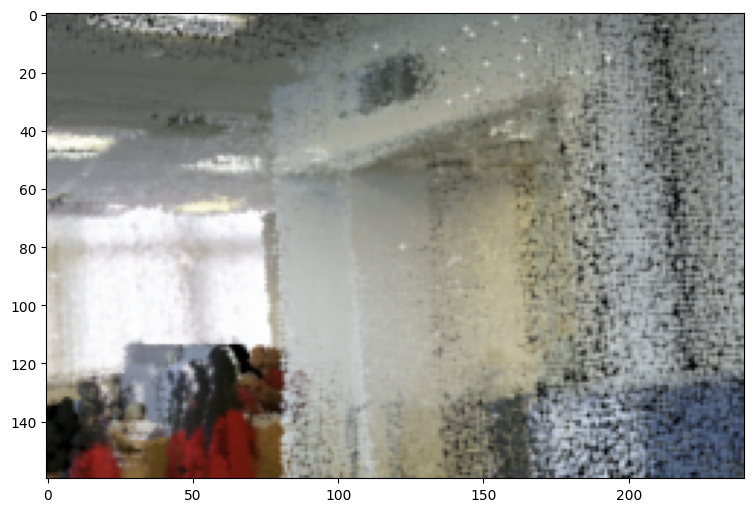

Padding Image
Extracting Patches
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features
Patch 0
Patch 10000
Patch 20000
Patch 30000
Extracting Patch Features


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.7s finished


Prediction Probability:  [[0.962 0.038]
 [0.966 0.034]
 [0.946 0.054]
 ...
 [0.986 0.014]
 [0.988 0.012]
 [0.998 0.002]]
Best prediction Probability:  [1 1 1 ... 1 1 1]
Sphere found. Finding location.


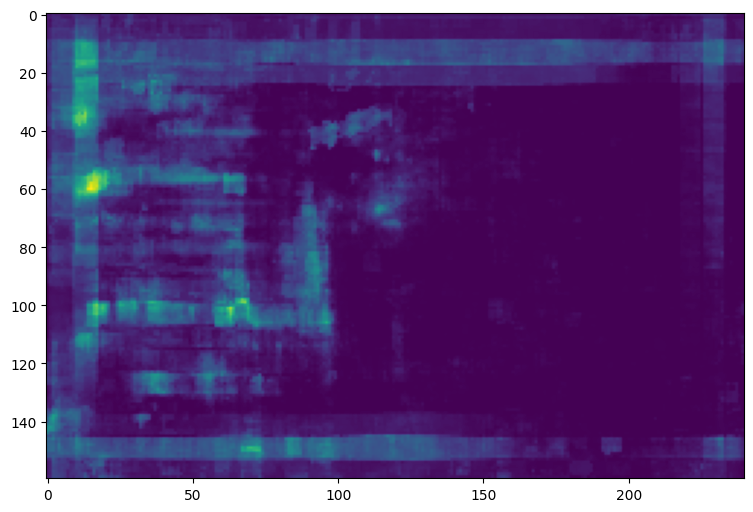

Updating Camera Position
New position: [-10.60777378   0.60440964  14.22636509]
Updating scene and list of collected spheres.


TypeError: only integer scalar arrays can be converted to a scalar index

In [39]:
iteration_counter = 0
start_time = time.time()
elapsed_time = time.time() - start_time
location_list = []
location_change_counter = 0
rotation_counter = 0
while not np.all(spheres_collected): # While there are spheres to find
    sphere_counter = sum(spheres_collected)
    # Get current image from viewpoint
    print('Capturing Image')
    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
    plt.imshow(image)
    plt.show()
    
    # Extract patches from the scene
    print('Padding Image')
    patch_range = np.asarray(training_data.shape[1:3]) // 2
#     adding 25 pixels worth of padding, both to the start and end of my two axes the height and the width (image with a border)
    image_padded = np.pad(image, [(patch_range[0],patch_range[0]),
                                 (patch_range[1],patch_range[1]),
                                 (0,0)], 'constant')
    
    plt.imshow(image_padded)
    
    # Extract features from the patches
    print('Extracting Patches')
    patches = []
    patch_counter = 0
    for i_row in range(patch_range[0], image.shape[0] + patch_range[0]):
        for i_col in range(patch_range[1], image.shape[1] + patch_range[0]):
            patches.append(image_padded[i_row - patch_range[0]:i_row + patch_range[0]+1,
                                       i_col - patch_range[1]:i_col + patch_range[1]+1])
            if (patch_counter % 10000) == 0:
                print(f'Patch {patch_counter}')
                #Progress Counter
            patch_counter += 1
            
    # Extract features from the patches
    print('Extracting Patch Features')
    patch_hog = []
    patch_counter = 0
    for patch in patches:
        patch_hog.append(skimage.feature.hog(patch, channel_axis=-1))
        if (patch_counter % 10000) == 0:
            print(f'Patch {patch_counter}')
        patch_counter += 1
    
    # Predict the probability of a pixel being a sphere, based on the patch
    print('Extracting Patch Features')
    test_features = np.asarray(patch_hog)
    prediction_probability = model.predict_proba(test_features)
    print("Prediction Probability: ", prediction_probability)
    print("Best prediction Probability: ", np.argmin(prediction_probability, axis=1))
    # Use probabilities to find sphere coordinates in 3D
    if not np.any(np.argmax(prediction_probability, axis=1)):
        # Update camera appropriately
        print('No sphere found. Roating camera')
        angle = angle + [0, -30 * np.pi / 180, 0] #Turn left
        rotation_counter += 1
        if rotation_counter >= 3:
            angle = angle + [0, 90 * np.pi / 180, 0]
            global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
            rotation_counter = 0
    else:
        # create heatmap of predictions
        print('Sphere found. Finding location.')
        predictive_heatmap = np.reshape(prediction_probability[:,1], image.shape[0:2])
        # Find where the highest probrablity of being a sphere
        best = np.unravel_index(np.argmax(predictive_heatmap), predictive_heatmap.shape)
        plt.imshow(predictive_heatmap)
        plt.show()
        
        previous_position = position
        # Update camera appropriately
        print('Updating Camera Position')
        position[0] = mapx[best[0], best[1]]
        position[1] = mapy[best[0], best[1]]
        position[2] = mapz[best[0], best[1]]
        print(f'New position: {position}')
        
        # Update scene if needed, if the camera goes out of bounds then it rotates instead
        print('Updating scene and list of collected spheres.')
        # if (numpy.count_nonzero(spheres_collected) != sphere_counter):
        try:
            global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
            print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!');
            # location_list.append(position)
            rotation_counter = 0
            print(f'Position: {position}')
            print(f'Previous Position: {previous_position}')
            if (sum(spheres_collected) > sphere_counter):
                sphere_counter = sum(spheres_collected)
            else:
                global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
                angle = angle + [0, -30 * np.pi / 180, 0] #Turn left
        except:
            # If error, go back to previous position and turn left
            global_cloud, spheres_collected = PacMan.update_scene(previous_position, spheres_collected);
            print("position was invalid, Turning camera left to look elsewhere")
            angle = angle + [0, -30 * np.pi / 180, 0] #Turn left
    
    # Model will automatically stop x iterations has been elapsed or time exceeds 20 mins
    iteration_counter += 1
    if (11 == np.count_nonzero(spheres_collected)):
        elapsed_time = time.time() - start_time
        break
    if (iteration_counter == 100) or (1200 < (time.time() - start_time)):
        print("Experiment Ended")
        break

In [40]:
count = np.count_nonzero(spheres_collected)
if count == 11:
    print(f'Congradulations!! All the spheres were collected in {elapsed_time} seconds and with {iteration_counter} iterations')
else:
    print(f'Sadly only {count} of the 11 spheres were collected. Better luck next time')

Sadly only 6 of the 11 spheres were collected. Better luck next time


In [ ]:
#Confusion Matrix to display results
# actual = numpy.random.binomial(1,.9,size = 1000)
# predicted = numpy.random.binomial(1,.9,size = 1000)

# print(model.predict(extracted_features, training_labels))
# predicted = model.predict(extracted_features)
# actual = model.predict(test_features)
# confusion_matrix = metrics.confusion_matrix(actual, predicted)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show()